In [6]:
!pip install tensorflow


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import time

In [8]:
tf.get_logger().setLevel('ERROR')

In [9]:
import sys
from PIL import Image
sys.modules['Image'] = Image

In [10]:
# Delete corrupted images
import os
num_skipped = 0
for folder_name in ("H", "S", "U"):
    folder_path = os.path.join("CameraTrainingDataset", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b'\xff\xd8\xff' in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


In [11]:
image_size = (240, 320)
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    "CameraTrainingDataset",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "CameraTrainingDataset",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 3030 files belonging to 3 classes.
Using 2424 files for training.
Found 3030 files belonging to 3 classes.
Using 606 files for validation.


In [12]:
class_names = train_ds.class_names
print(class_names)

['H', 'S', 'U']


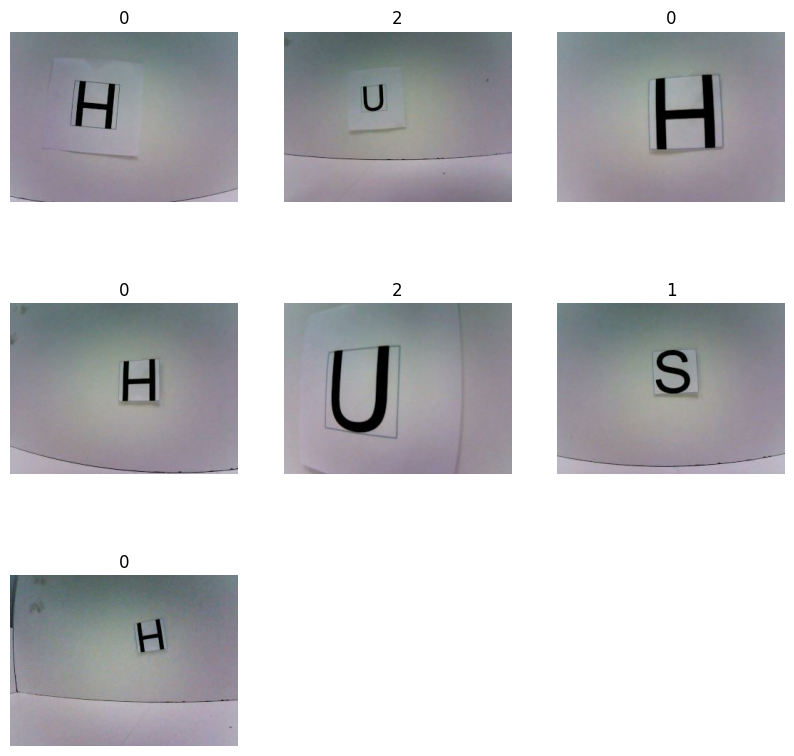

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(7):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [14]:
data_augmentation = keras.Sequential(
    [
        layers.RandomTranslation(height_factor=0.2, width_factor=0.2, fill_mode="constant"),
        layers.RandomFlip("horizontal", input_shape=image_size + (3,)),
        layers.RandomZoom(0.05),
    ]
)

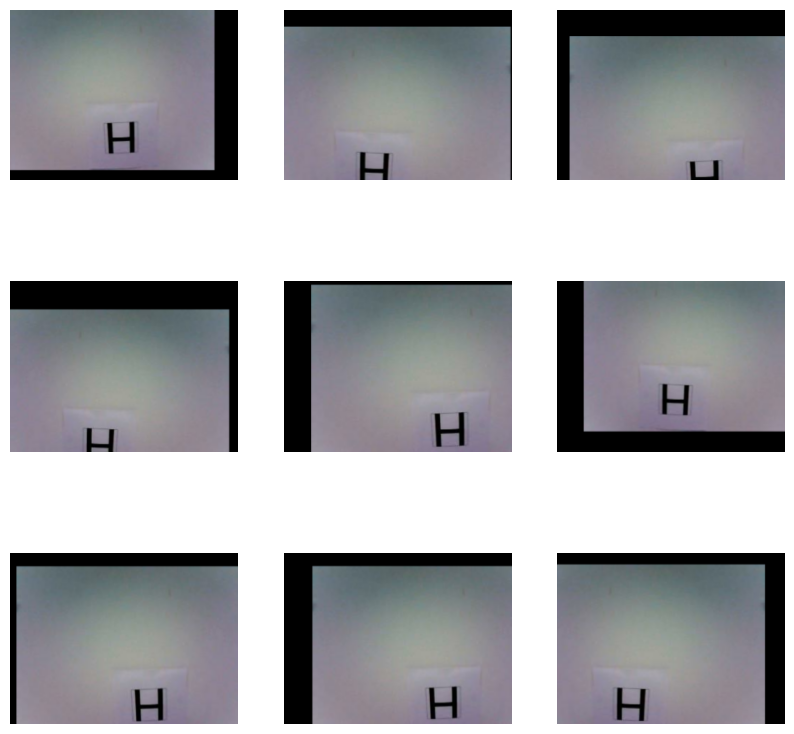

In [15]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [16]:
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y))

In [17]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [18]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

normalization_layer = layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

In [19]:
def make_simple_model(input_shape, num_classes):
    model = keras.Sequential(
        [
            keras.Input(shape=input_shape),
            layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dropout(0.5),
            layers.Dense(num_classes, activation="softmax"),
        ]
    )
    
    return model

In [20]:
def make_tf_simple_model(input_shape, num_classes):
    model = keras.Sequential([
      data_augmentation,
      layers.Rescaling(1./255, input_shape=input_shape),
      layers.Conv2D(16, 3, padding='same', activation='relu'),
      layers.BatchNormalization(),
      layers.MaxPooling2D(),
      layers.Conv2D(32, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(64, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Dropout(0.2),
      layers.Flatten(),
      layers.Dense(128, activation='relu'),
      layers.Dense(num_classes, name="outputs")
    ])
    
    return model


In [21]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

In [22]:
model = make_tf_simple_model(input_shape=image_size + (3,), num_classes=3)

default_epochs = 200

In [23]:
def fit_model(epochs = 100):
    callbacks = [
        keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
    ]
    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    print(train_ds)

    (x_train, y_train) = train_ds
    (x_test, y_test) = val_ds

    y_train = to_categorical(y_train, 7)
    y_test = to_categorical(y_test, 7)

    history = model.fit(
        x_train,
        y_train,
        epochs=epochs,
        callbacks=callbacks,
        validation_data=(x_test, y_test),
    )
    
    return history

In [24]:
def fit_tf_simple_model(epochs = 100):
    model.compile(optimizer=keras.optimizers.Adam(1e-3),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

    history = model.fit(
      train_ds,
      validation_data=val_ds,
      epochs=epochs
    )
    
    return history

In [25]:
# history = fit_model(default_epochs)
history = fit_tf_simple_model(default_epochs)

Epoch 1/200
76/76 [==============================] - 71s 922ms/step - loss: 2.3133 - accuracy: 0.3185 - val_loss: 1.0978 - val_accuracy: 0.3614
Epoch 2/200
76/76 [==============================] - 72s 944ms/step - loss: 1.0900 - accuracy: 0.4031 - val_loss: 1.0966 - val_accuracy: 0.3614
Epoch 3/200
76/76 [==============================] - 73s 956ms/step - loss: 1.0538 - accuracy: 0.4542 - val_loss: 1.0631 - val_accuracy: 0.6469
Epoch 4/200
76/76 [==============================] - 69s 915ms/step - loss: 0.6851 - accuracy: 0.7034 - val_loss: 0.8781 - val_accuracy: 0.7789
Epoch 5/200
76/76 [==============================] - 71s 934ms/step - loss: 0.3786 - accuracy: 0.8634 - val_loss: 12.2389 - val_accuracy: 0.3399
Epoch 6/200
76/76 [==============================] - 69s 914ms/step - loss: 0.2845 - accuracy: 0.8993 - val_loss: 1.6300 - val_accuracy: 0.3696
Epoch 7/200
76/76 [==============================] - 74s 970ms/step - loss: 0.2644 - accuracy: 0.9035 - val_loss: 0.1425 - val_accuracy

KeyboardInterrupt: 

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(default_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
from keras_visualizer import visualizer
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
visualizer(model, format='png', view=True) # open image file after visualization

In [ ]:
model.save('tfModel.keras')

In [ ]:
# Convert the model to ft Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

In [ ]:
tflite_model.save('tfLiteModel.keras')

In [ ]:
img = keras.preprocessing.image.load_img(
    "Signs/OP/O_193231-606919_l.png", target_size=image_size
)

In [ ]:
img = keras.preprocessing.image.load_img(
    "CameraTrainingDataset/H/00000.jpg", target_size=image_size
)

In [ ]:
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

start = time.process_time() 
predictions = model.predict(img_array)
end = time.process_time()

print("Time: {}s".format(end-start)) 
print(list(map(lambda p, c: (c, p),predictions[0], class_names)))
